In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.9,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_09_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:44 - loss: 0.1128 - STD: 8.5986e-05 - MAE: 0.3254

 12/632 [..............................] - ETA: 2s - loss: 0.0340 - STD: 2.5108e-04 - MAE: 0.1373   

 22/632 [>.............................] - ETA: 3s - loss: 0.0253 - STD: 2.4909e-04 - MAE: 0.1178

 32/632 [>.............................] - ETA: 3s - loss: 0.0216 - STD: 2.4126e-04 - MAE: 0.1011

 42/632 [>.............................] - ETA: 2s - loss: 0.0196 - STD: 2.6153e-04 - MAE: 0.0947

 53/632 [=>............................] - ETA: 2s - loss: 0.0182 - STD: 3.0677e-04 - MAE: 0.0897

 65/632 [==>...........................] - ETA: 2s - loss: 0.0172 - STD: 4.0403e-04 - MAE: 0.0863

 76/632 [==>...........................] - ETA: 2s - loss: 0.0165 - STD: 5.7114e-04 - MAE: 0.0836

 86/632 [===>..........................] - ETA: 2s - loss: 0.0160 - STD: 8.6545e-04 - MAE: 0.0818

 96/632 [===>..........................] - ETA: 2s - loss: 0.0156 - STD: 0.0015 - MAE: 0.0805    

107/632 [====>.........................] - ETA: 2s - loss: 0.0150 - STD: 0.0030 - MAE: 0.0784

119/632 [====>.........................] - ETA: 2s - loss: 0.0143 - STD: 0.0067 - MAE: 0.0758

131/632 [=====>........................] - ETA: 2s - loss: 0.0134 - STD: 0.0127 - MAE: 0.0728

142/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 0.0187 - MAE: 0.0701

154/632 [======>.......................] - ETA: 2s - loss: 0.0119 - STD: 0.0246 - MAE: 0.0675

166/632 [======>.......................] - ETA: 2s - loss: 0.0113 - STD: 0.0300 - MAE: 0.0652

178/632 [=======>......................] - ETA: 2s - loss: 0.0107 - STD: 0.0346 - MAE: 0.0631

191/632 [========>.....................] - ETA: 2s - loss: 0.0102 - STD: 0.0390 - MAE: 0.0611

204/632 [========>.....................] - ETA: 1s - loss: 0.0097 - STD: 0.0429 - MAE: 0.0594

217/632 [=========>....................] - ETA: 1s - loss: 0.0093 - STD: 0.0463 - MAE: 0.0578

230/632 [=========>....................] - ETA: 1s - loss: 0.0089 - STD: 0.0493 - MAE: 0.0563

243/632 [==========>...................] - ETA: 1s - loss: 0.0085 - STD: 0.0522 - MAE: 0.0550

256/632 [===========>..................] - ETA: 1s - loss: 0.0082 - STD: 0.0546 - MAE: 0.0537

269/632 [===========>..................] - ETA: 1s - loss: 0.0079 - STD: 0.0569 - MAE: 0.0526

282/632 [============>.................] - ETA: 1s - loss: 0.0076 - STD: 0.0590 - MAE: 0.0515

295/632 [=============>................] - ETA: 1s - loss: 0.0074 - STD: 0.0610 - MAE: 0.0506

308/632 [=============>................] - ETA: 1s - loss: 0.0071 - STD: 0.0627 - MAE: 0.0497

321/632 [==============>...............] - ETA: 1s - loss: 0.0069 - STD: 0.0644 - MAE: 0.0489

332/632 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0657 - MAE: 0.0482

342/632 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0668 - MAE: 0.0476

354/632 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0680 - MAE: 0.0470

365/632 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0691 - MAE: 0.0464

376/632 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0701 - MAE: 0.0459

387/632 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0454

398/632 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0719 - MAE: 0.0450

408/632 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0727 - MAE: 0.0445

419/632 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0735 - MAE: 0.0441

431/632 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0436

442/632 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0433

453/632 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0758 - MAE: 0.0429

465/632 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0764 - MAE: 0.0425

477/632 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0421

489/632 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0777 - MAE: 0.0418

501/632 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0414

513/632 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0411

524/632 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0409

536/632 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0406

547/632 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0403

558/632 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0401

570/632 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0399

582/632 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0396

594/632 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0394

606/632 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0391

619/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0834 - MAE: 0.0389

632/632 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0387

632/632 [==============================] - 5s 6ms/step - loss: 0.0043 - STD: 0.0838 - MAE: 0.0387 - val_loss: 0.0019 - val_STD: 0.0814 - val_MAE: 0.0303


Epoch 2/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0262

 13/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0268 

 23/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0264

 33/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

 43/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0270

 55/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0271

 67/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0270

 78/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0270

 88/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0272

 98/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0272

108/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0271

118/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0271

129/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0270

139/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0270

149/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0270

159/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0270

170/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0270

181/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0271

191/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0271

201/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0271

211/632 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0271

221/632 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0271

232/632 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

242/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0271

252/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0271

262/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0271

272/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0271

283/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

293/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271

303/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271

313/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271

323/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271

333/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271

343/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

354/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

364/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

373/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

383/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

393/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

403/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

413/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

423/632 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

432/632 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

442/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

452/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

461/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

471/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

481/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

491/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

501/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

511/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

522/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

532/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

542/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

552/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

565/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

577/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

589/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

601/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

613/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

625/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

632/632 [==============================] - 3s 6ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269 - val_loss: 0.0016 - val_STD: 0.0820 - val_MAE: 0.0284


Epoch 3/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.1140 - MAE: 0.0256

 11/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264 

 21/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

 31/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

 41/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0268

 51/632 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

 63/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

 75/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

 87/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

 98/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

109/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

119/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

130/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

140/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

150/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

160/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

170/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

180/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

191/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

203/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

214/632 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

226/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

238/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

248/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

258/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

269/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

282/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

292/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

302/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

314/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

327/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

339/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

352/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

365/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

376/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

388/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

400/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

412/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

424/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

436/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

448/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

460/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

471/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

483/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

495/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

507/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

519/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

532/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

544/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

556/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

568/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

580/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

592/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

604/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

617/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

629/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263 - val_loss: 0.0017 - val_STD: 0.0830 - val_MAE: 0.0284


Epoch 4/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0252

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0252 

 22/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

 34/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

 46/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

 58/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

 70/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

 82/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

 95/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

106/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

118/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

130/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

142/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

154/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

166/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

178/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0264

190/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

202/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

214/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

226/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

238/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

250/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

263/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

275/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

288/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

299/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

309/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

320/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

331/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

341/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

351/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

361/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

372/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

383/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

393/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

405/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

416/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

427/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

438/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

450/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

463/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

476/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

489/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

502/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

515/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

527/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

539/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

551/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

563/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

576/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

588/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

600/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

612/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

624/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259 - val_loss: 0.0015 - val_STD: 0.0808 - val_MAE: 0.0278


Epoch 5/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0013 - STD: 0.1007 - MAE: 0.0248

 12/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

 22/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

 32/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

 43/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

 53/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

 63/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

 73/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

 85/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

 97/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

109/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

121/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0254

133/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

145/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

157/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

167/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

177/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0254

188/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0254

200/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

212/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

224/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

236/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

248/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

260/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

272/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

284/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

296/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

320/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

332/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

344/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

356/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

368/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

380/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

392/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

405/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

417/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

429/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

442/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

454/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

466/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

478/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

490/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

502/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

514/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

526/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

538/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

550/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

562/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

575/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

588/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

601/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

613/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

625/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255 - val_loss: 0.0023 - val_STD: 0.0852 - val_MAE: 0.0340


Epoch 6/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0015 - STD: 0.1131 - MAE: 0.0267

 12/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0265 

 24/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

 36/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0255

 48/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

 61/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

 74/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

 86/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

 99/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

111/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0250

123/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

135/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

147/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

159/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

170/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

180/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

190/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

200/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

210/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

220/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

230/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

240/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

250/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

260/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

271/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

281/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

291/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

301/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

311/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

323/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

335/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

346/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

357/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

368/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

379/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

392/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

403/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

415/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

426/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

438/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

448/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

458/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

469/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

479/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

491/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

503/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

513/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

523/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

533/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

544/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

555/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

566/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

577/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

588/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

598/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

610/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

622/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250 - val_loss: 0.0016 - val_STD: 0.0851 - val_MAE: 0.0277


Epoch 7/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0012 - STD: 0.1078 - MAE: 0.0241

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250 

 22/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0250

 35/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0253

 48/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

 59/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

 69/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

 80/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

 92/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

104/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

115/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

125/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

135/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

145/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

155/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

165/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

175/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

185/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

196/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

207/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

219/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

230/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

240/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

251/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

262/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

273/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

283/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

293/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

304/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

314/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

324/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

335/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

347/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

359/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

369/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

380/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

391/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

402/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

413/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

424/632 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

435/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

447/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

458/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

469/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

479/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

491/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

504/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

517/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

530/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

543/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

555/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

566/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

576/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

587/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

598/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

609/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

619/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

630/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248 - val_loss: 0.0021 - val_STD: 0.0850 - val_MAE: 0.0317


Epoch 8/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0244

 11/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237 

 21/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0240

 31/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0240

 41/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0241

 51/632 [=>............................] - ETA: 3s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

 62/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

 74/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

 85/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

 95/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

105/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

115/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

125/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

135/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

145/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0243

155/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0243

166/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

176/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

186/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0243

197/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

207/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

217/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

227/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

237/632 [==========>...................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

247/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

257/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

267/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

277/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

287/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

297/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

307/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

317/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

327/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

337/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

347/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

357/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

367/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

377/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

387/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

398/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

408/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

418/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

429/632 [===================>..........] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

441/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

453/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

464/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

476/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

488/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

500/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

512/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0243

524/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0243

536/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

548/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

560/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

571/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

582/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

593/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

604/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

616/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

629/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243 - val_loss: 0.0016 - val_STD: 0.0859 - val_MAE: 0.0274


Epoch 9/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.1108 - MAE: 0.0240

 12/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0238 

 24/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

 36/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

 49/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

 61/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1078 - MAE: 0.0240

 73/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0241

 86/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0243

 98/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0244

110/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0244

122/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0244

134/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0243

146/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0242

158/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0241

170/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0241

182/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0241

194/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0241

207/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0240

219/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0240

231/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0240

243/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

255/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

268/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

281/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

294/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

306/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

318/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

330/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

342/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

354/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

367/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

379/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

392/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

404/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

416/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

428/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

441/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

453/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

465/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

477/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

489/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

501/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

513/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

525/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

537/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

549/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

561/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

573/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

585/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

598/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

610/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

622/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237 - val_loss: 0.0021 - val_STD: 0.0889 - val_MAE: 0.0305


Epoch 10/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.1090 - MAE: 0.0233

 13/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1083 - MAE: 0.0238 

 25/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1088 - MAE: 0.0236

 37/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1085 - MAE: 0.0240

 49/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0239

 61/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

 73/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

 86/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

 99/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0239

112/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

124/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

137/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

150/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0237

162/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0237

174/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0237

186/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0237

198/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0237

209/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

220/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

233/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

244/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

255/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

267/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

280/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

292/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

305/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

318/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

330/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0237

343/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0237

355/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

367/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

379/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

391/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

401/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

412/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

424/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

436/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

448/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

460/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

472/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

484/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

496/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

508/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

520/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

532/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

545/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

558/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

570/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

582/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

595/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

608/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

620/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235 - val_loss: 0.0019 - val_STD: 0.0889 - val_MAE: 0.0291


Epoch 11/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0011 - STD: 0.1085 - MAE: 0.0234

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1089 - MAE: 0.0233 

 23/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1089 - MAE: 0.0232

 34/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1091 - MAE: 0.0232

 44/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1085 - MAE: 0.0232

 55/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0232

 67/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0232

 78/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0234

 89/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0235

101/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0235

113/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0235

125/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0234

137/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0234

149/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0233

161/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0233

174/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0233

185/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

196/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

206/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

217/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

227/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

238/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

248/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

258/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

268/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

278/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

288/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

299/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

310/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

321/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

331/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

341/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

351/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

361/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

371/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

381/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

391/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

401/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

411/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

421/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

432/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

442/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

452/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

462/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

472/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

482/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

492/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

502/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

512/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

523/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

535/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

546/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

557/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

569/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

581/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

592/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

603/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

613/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

623/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231 - val_loss: 0.0024 - val_STD: 0.0894 - val_MAE: 0.0322


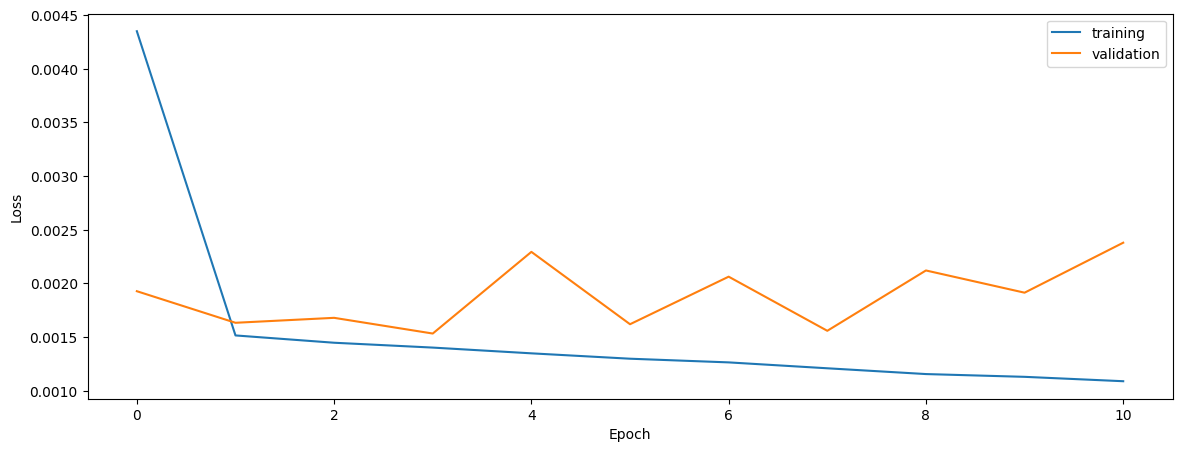

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9469798476487323
0.957686665458368
0.9472249173103638


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9470719785710309
0.9543973422123003
0.9504744196434726


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9535918239623311
0.9562101800998201
0.9620606988930795


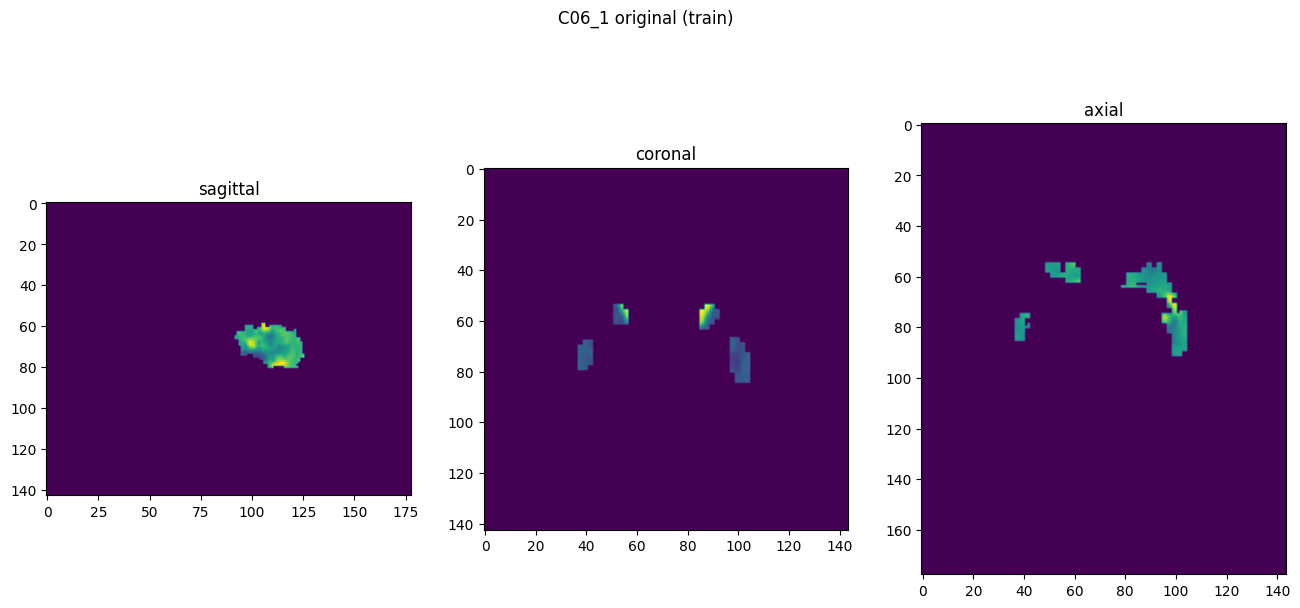

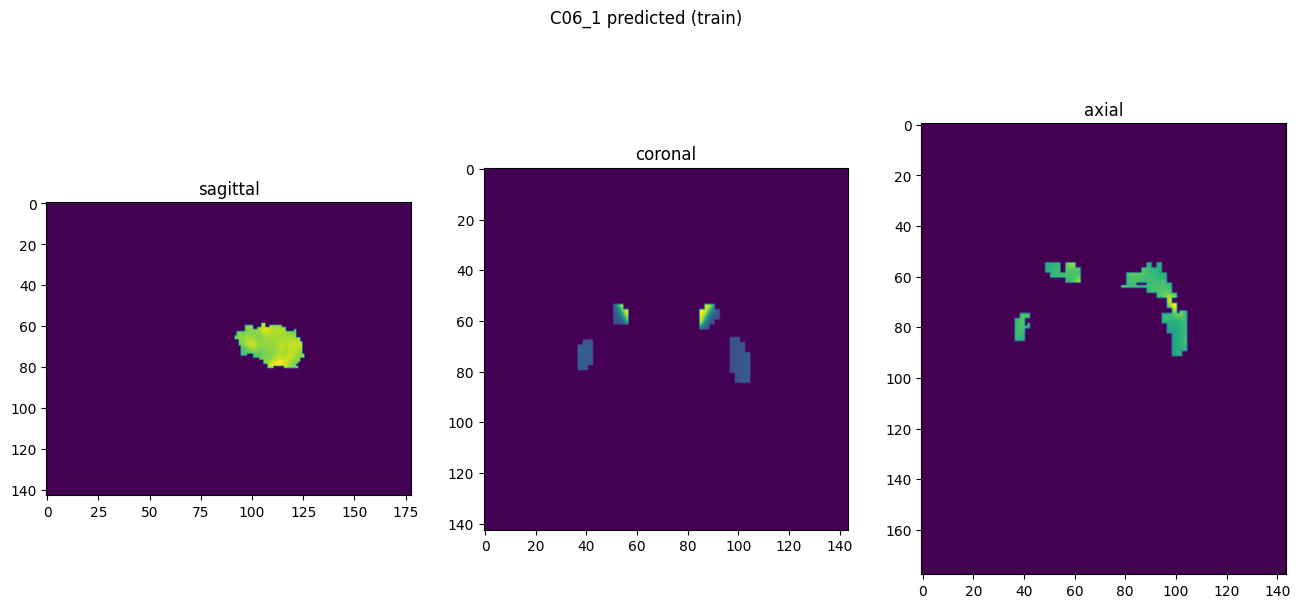

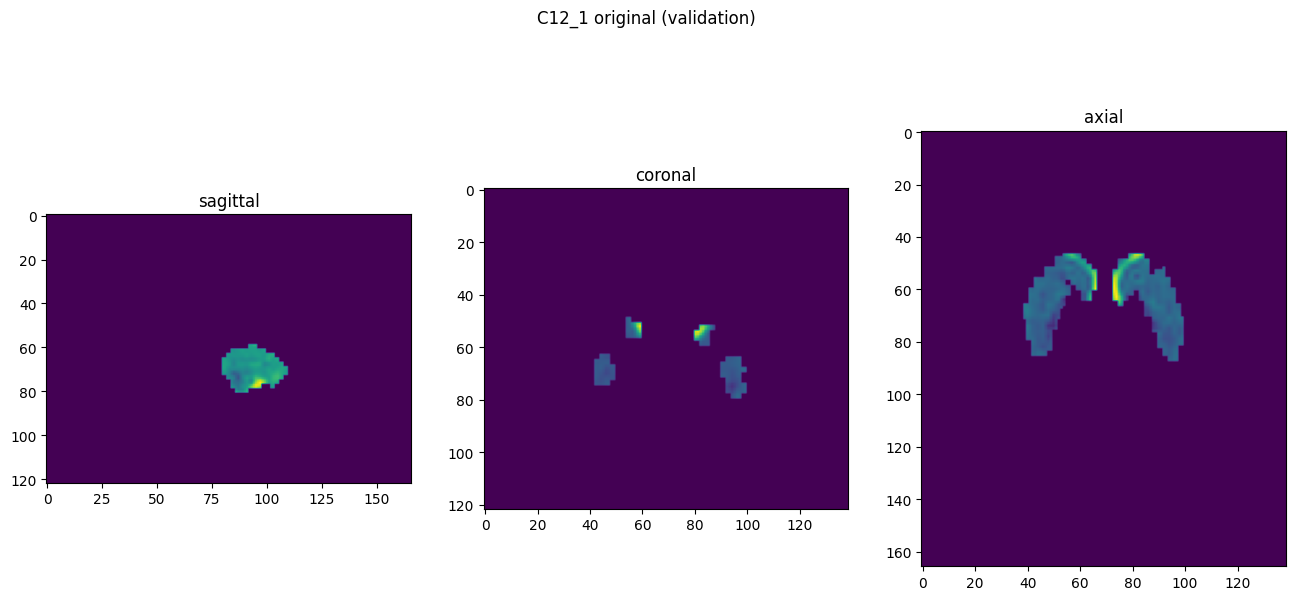

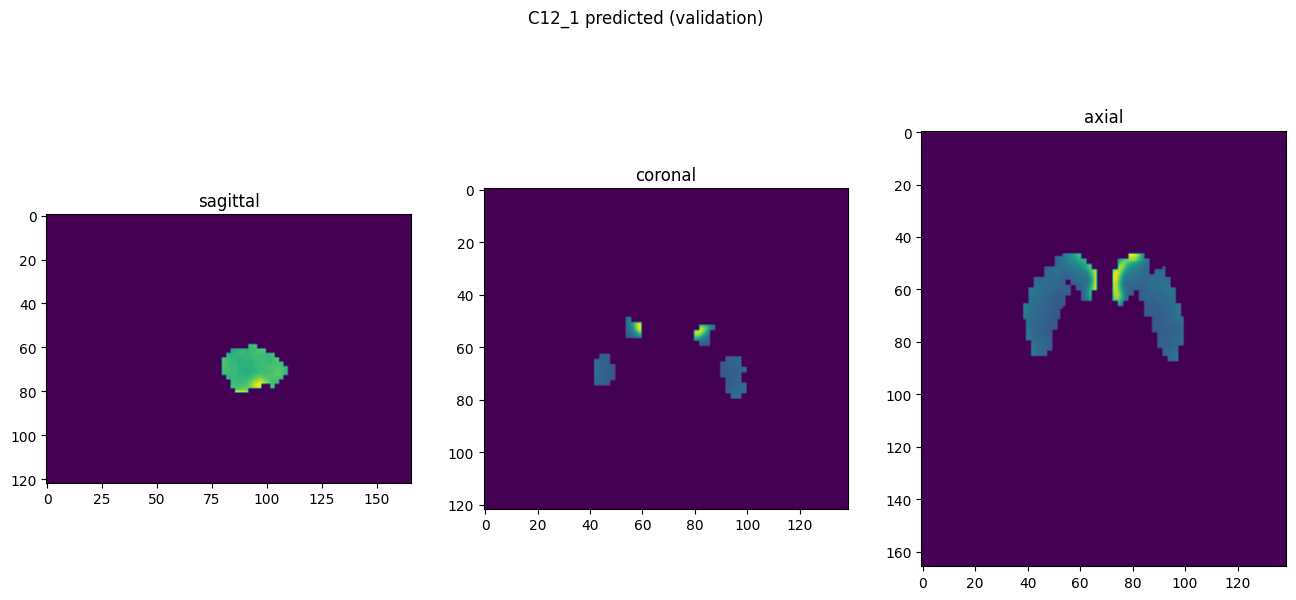

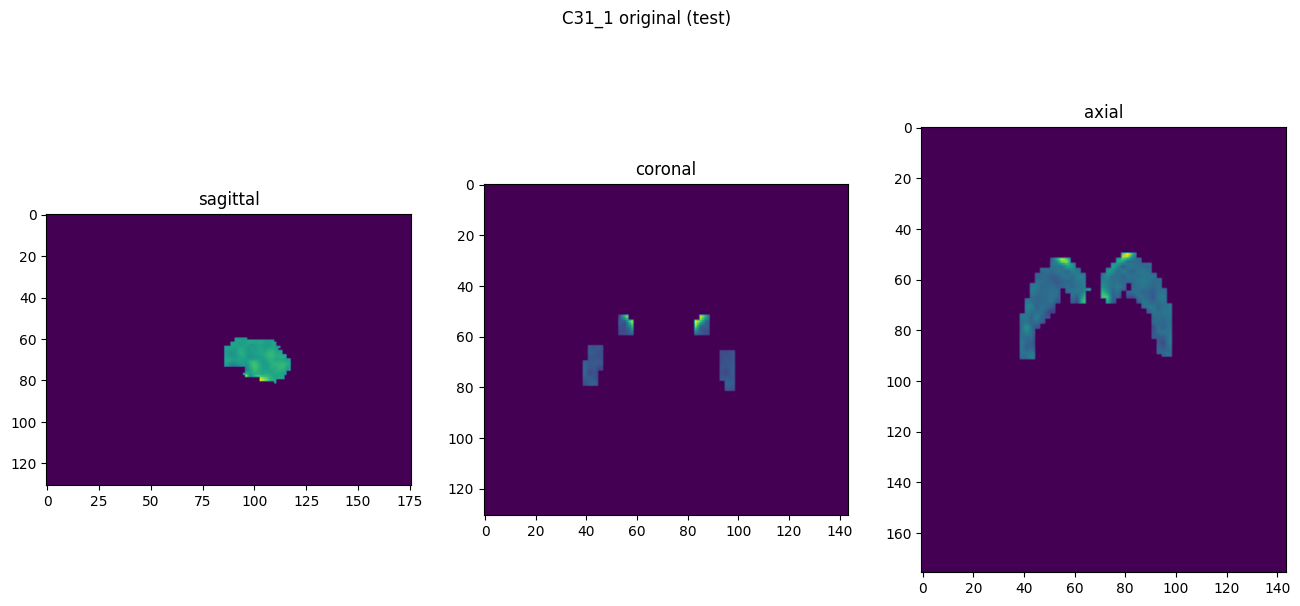

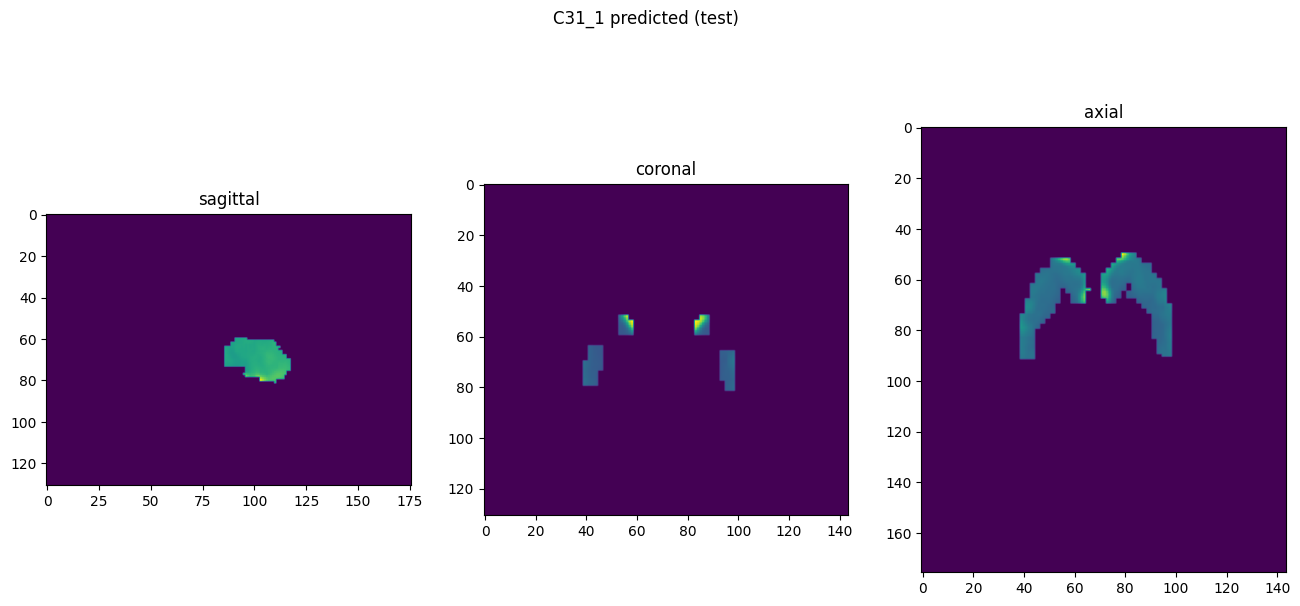

In [10]:
showResults(model, gen, threshold=None, background=False)